In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['FB','AMZN','GOOG','TWTR','TSLA']**

In [2]:
import yfinance as yf
stock_symbol = 'GOOG'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-03-21,2736.949951,2751.649902,2692.229980,2729.570068,2729.570068,1331600
501,2022-03-22,2730.000000,2830.000000,2730.000000,2805.550049,2805.550049,1488800
502,2022-03-23,2782.770020,2800.500000,2763.330078,2770.070068,2770.070068,1265100
503,2022-03-24,2785.449951,2827.929932,2760.788086,2826.239990,2826.239990,1027200
504,2022-03-25,2835.080078,2839.189941,2793.989990,2830.429932,2830.429932,963500


#### Visualizing the Real Stock Trend

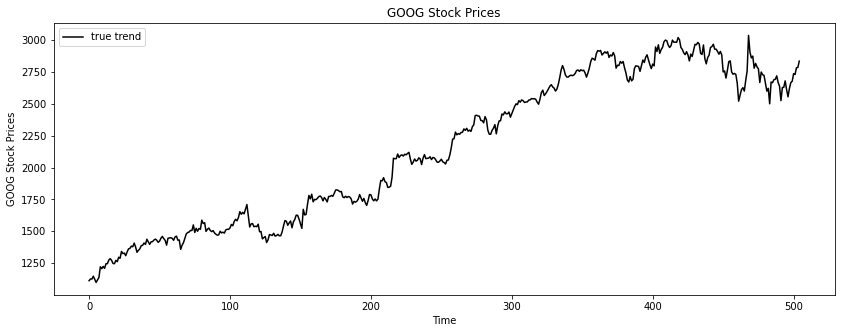

In [3]:
plt.figure(figsize=(14,5))
plt.plot(data['Open'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [4]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

#### Preparing the training data

In [5]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,1111.800049,1169.969971,1093.530029,1161.750000,3571700
1,1125.670044,1150.670044,1105.910034,1110.709961,3208500
2,1125.040039,1151.630005,1096.479980,1146.819946,2574100
3,1147.300049,1175.310059,1138.140015,1162.810059,2486400
4,1122.000000,1129.689941,1097.449951,1105.619995,2344200


In [6]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.00704572, 0.02426491, 0.00715349, 0.03332985, 0.8098084 ])

In [7]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,0])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape
# 385 rows
# 60 columns
# 5 dimentional data

((385, 60, 5), (385,))

#### Preparaing testing data

In [8]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((120, 5),
             Open         High          Low        Close   Volume
 385  2680.000000  2747.239990  2680.000000  2723.540039  1206300
 386  2692.510010  2757.040039  2689.729980  2747.080078   988200
 387  2777.260010  2803.089111  2771.260010  2783.709961   912500
 388  2798.120117  2806.340088  2788.586914  2801.120117   946200
 389  2796.000000  2815.272949  2776.129883  2776.949951   829200)

In [9]:
df = scaler.transform(df)
df[0]

array([0.823077  , 0.84856751, 0.83432745, 0.84833277, 0.21583005])

In [10]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,0])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [11]:
# below is the scaling label, 
# therefore we need to divide our y_pred with the below scaling value it used to scale the data
scaler.scale_

array([5.20361758e-04, 5.22613496e-04, 5.21392760e-04, 5.21838980e-04,
       2.51111167e-07])

In [12]:
scale = 1/8.50296711e-04
scale

1176.0600588751424

In [13]:
y_test = y_test*scale

### LSTM - Long Short-Term Memory

In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

In [15]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [16]:
regression = Sequential()

# Input layer
regression.add(LSTM(units=40,activation='relu',return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
regression.add(Dropout(0.2))

# 2nd layer (Hidden)
regression.add(LSTM(units=60,activation='relu',return_sequences=True))
regression.add(Dropout(0.2))

# 3rd layer (Hidden)
#regression.add(LSTM(units=80,activation='relu',return_sequences=True))
#regression.add(Dropout(0.2))

# 4th layer (Hidden)
regression.add(LSTM(units=80,activation='relu'))
regression.add(Dropout(0.5))

# Outer layer
regression.add(Dense(units=1))
regression.add(Activation('linear'))

regression.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 40)            7360      
                                                                 
 dropout (Dropout)           (None, 60, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            24240     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 80)                45120     
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 8

In [17]:
regression.compile(optimizer='adam',loss='mean_squared_error',metrics='accuracy')

In [18]:
def forecast():
    regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred*scale
    return y_pred

In [19]:
def first_forecast():
    history = regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred*scale
    return history,y_pred

In [20]:
result_forecast = []
simulation = 1
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300
13/13 [==============================] - 8s 228ms/step - loss: 0.1686 - accuracy: 0.0000e+00
Epoch 2/300
13/13 [==============================] - 3s 208ms/step - loss: 0.0569 - accuracy: 0.0026
Epoch 3/300
13/13 [==============================] - 3s 207ms/step - loss: 0.0298 - accuracy: 0.0026
Epoch 4/300
13/13 [==============================] - 3s 211ms/step - loss: 0.0291 - accuracy: 0.0026
Epoch 5/300
13/13 [==============================] - 3s 213ms/step - loss: 0.0197 - accuracy: 0.0026
Epoch 6/300
13/13 [==============================] - 3s 211ms/step - loss: 0.0236 - accuracy: 0.0026
Epoch 7/300
13/13 [==============================] - 2s 185ms/step - loss: 0.0168 - accuracy: 0.0026
Epoch 8/300
13/13 [==============================] - 3s 195ms/step - loss: 0.0184 - accuracy: 0.0026
Epoch 9/300
13/13 [==============================] - 3s 205ms/step - loss: 0.0166 - accuracy: 0.0026
Epoch 10/300
13/13 [==============================] - 3s 200ms/step - loss

#### Calculating the Accuracy using MAPE

In [29]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    # mean Absolute Percentage Error - MAPE
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[92.395958246929, 92.395958246929, 92.395958246929, 92.395958246929]

In [22]:
# RMSE - Root Mean Squared Error 
temp = 1 - np.sqrt(np.mean(np.square((y_test - result_forecast[0])/y_test)))
temp*100

90.79143799996949

#### Visualization

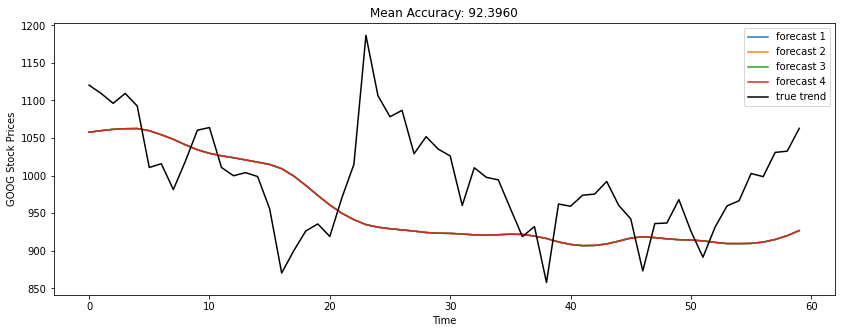

In [30]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

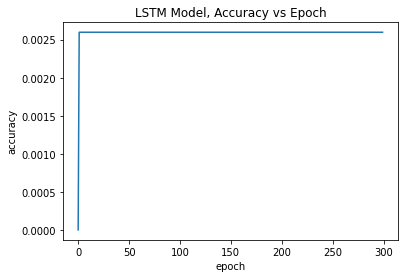

In [25]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('LSTM Model, Accuracy vs Epoch')
plt.show()

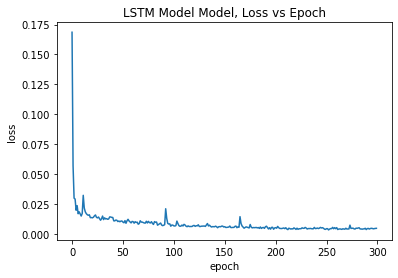

In [26]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('LSTM Model Model, Loss vs Epoch')
plt.show()

### Analysis

**Trial 1**
>**Dataset:**
>* GOOG
>* 2y  
>
>**Training Timestamp:**
>* 30 days 
>
>**Model:**
>* 4 layers
>* activation = relu
>* units = 40,60,80,120
>* dropout = 0.2,0.2,0.2,0.5
>* dense units = 1  
>
>**Compile:**
>* optimizer = adam
>
>**Traiing:**
>* epochs: 300
>* batch_size = 32
>
>**Accuracy:**
>* MAPE - 81.32%
>* RMSE - 80.36%

**Trial 2**
>**Dataset:**
>* GOOG
>* 2y
>  
>**Training Timestamp:**
>* 30 days
>
>**Model:**
>* 4 layers
>* activation = relu
>* units = 40,60,80,120
>* dropout = 0.2,0.2,0.2,0.5
>* dense units = 1  
>
>**Compile:**
>* optimizer = adam
>
>**Training:**
>* epochs: 100
>* batch_size = 32
>
>**Accuracy:**
>* MAPE - 88.76%
>* RMSE - 86.73%

**Trial 2**
>**Dataset:**
>* GOOG
>* 2y
>  
>**Training Timestamp:**
>* 60 days
>
>**Model:**
>* 3 layers
>* activation = relu
>* units = 40,60,80,120
>* dropout = 0.2,0.2,0.2,0.5
>* dense units = 1  
>
>**Compile:**
>* optimizer = adam
>
>**Training:**
>* epochs: 100
>* batch_size = 32
>
>**Accuracy:**
>* MAPE - 88.76%
>* RMSE - 86.73%